# Proyek Akhir: Sistem Rekomendasi MovieLens 100K
Script lengkap untuk:
1. Setup & Download Dataset  
2. Load Data  
3. Business Understanding & EDA  
4. Data Preparation  
5. Modeling & Evaluation  
6. Hybrid Analysis & Reporting  
7. Testing & Rekomendasi


**Deskripsi:** Mengimpor library yang diperlukan untuk pengolahan data, visualisasi, dan pemodelan.

In [25]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from kaggle.api.kaggle_api_extended import KaggleApi
from surprise import Reader, Dataset, SVD, accuracy
from surprise.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

## 1. Setup & Download Dataset

**Tujuan:** Menyiapkan lingkungan kerja dan mengunduh data MovieLens 100K dari Kaggle.

In [26]:
api = KaggleApi()
api.authenticate()
dataset_name = 'prajitdatta/movielens-100k-dataset'
download_path = './dataset'
if not os.path.exists(os.path.join(download_path, 'ml-100k')):
    api.dataset_download_files(dataset_name, path=download_path, unzip=True)

def print_tree(path, max_depth=2):
    for root, dirs, files in os.walk(path):
        depth = root.replace(path, '').count(os.sep)
        if depth <= max_depth:
            indent = ' ' * (4 * depth)
            print(f"{indent}{os.path.basename(root)}/")
            for f in files:
                print(f"{indent}    {f}")

print("Dataset structure:")
print_tree(download_path)

Dataset structure:
dataset/
    ml-100k/
        allbut.pl
        mku.sh
        README
        u.data
        u.genre
        u.info
        u.item
        u.occupation
        u.user
        u1.base
        u1.test
        u2.base
        u2.test
        u3.base
        u3.test
        u4.base
        u4.test
        u5.base
        u5.test
        ua.base
        ua.test
        ub.base
        ub.test


**Hasil:** Struktur folder dataset berhasil ditampilkan, memastikan file .data, .item, .user tersedia.

## 2. Load Data
**Tujuan:** Memuat file `u.data`, `u.item`, dan `u.user` ke dalam DataFrame pandas.


In [27]:
data_path = os.path.join(download_path, 'ml-100k')
ratings = pd.read_csv(os.path.join(data_path, 'u.data'), sep='\t',
                      names=['user_id','movie_id','rating','timestamp'], engine='python')
movies = pd.read_csv(os.path.join(data_path, 'u.item'), sep='|', encoding='latin-1',
                     names=['movie_id','title','release_date','video_release_date','IMDb_URL',
                            'unknown','Action','Adventure','Animation','Children','Comedy',
                            'Crime','Documentary','Drama','Fantasy','Film-Noir','Horror',
                            'Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western'],
                     engine='python')
users = pd.read_csv(os.path.join(data_path, 'u.user'), sep='|',
                    names=['user_id','age','gender','occupation','zip_code'], engine='python')
print("Data berhasil di-load!")

Data berhasil di-load!


**Insight:**

* Ratings: 100.000 baris interaksi pengguna-film.
* Movies: 1682 film dengan metadata genre.
* Users: 943 pengguna dengan atribut demografi.

---

## 3. Business Understanding & EDA

### 3.1 Project Overview & Problem Statement

**Problem Statement:**

* Pengguna kesulitan menemukan film sesuai preferensi.
* Sistem butuh menangani cold-start.
* Engagement perlu ditingkatkan.

**Goals:**

1. (Problem 1) Membangun sistem hybrid recommendation.
2. (Problem 2) Menangani cold-start dengan fallback populer.
3. (Problem 3) Meningkatkan engagement melalui evaluasi diversity score.

---

### 3.2 Exploratory Data Analysis
**Tujuan:** Memahami distribusi rating, genre, usia, dan masalah cold start.


In [28]:
def plot_bar(x, y, title, xlabel, ylabel, invert=False):
    plt.figure(figsize=(8,4))
    plt.bar(x, y)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if invert: plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

### 3.2.2 Top-10 Film by jumlah rating & rata-rata

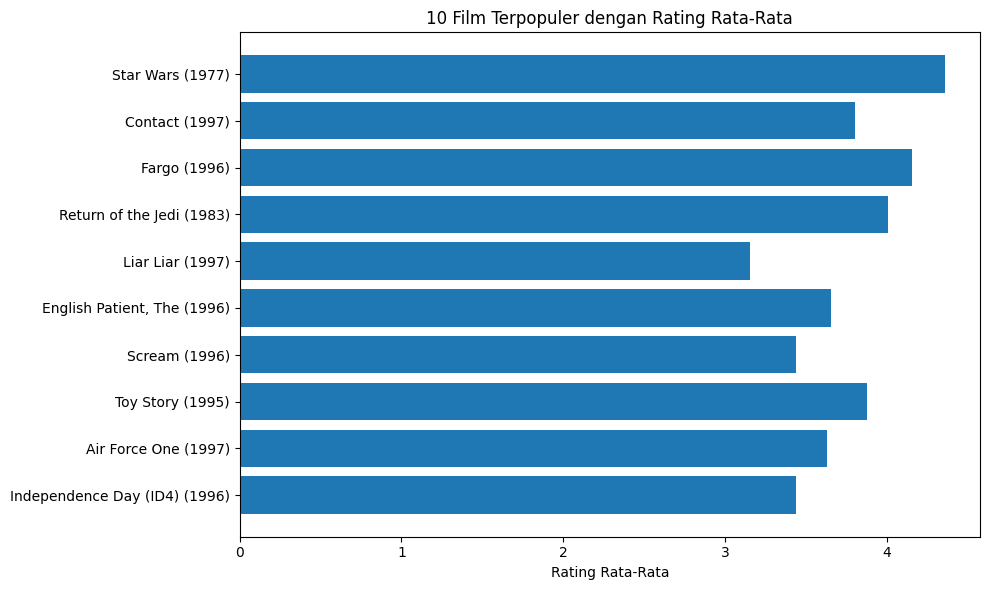

In [29]:
top10_ids = ratings['movie_id'].value_counts().head(10).index
top10 = movies.set_index('movie_id').loc[top10_ids, 'title']
avg_ratings = ratings.groupby('movie_id')['rating'].mean()
plt.figure(figsize=(10,6))
plt.barh([top10[mid] for mid in top10_ids], [avg_ratings[mid] for mid in top10_ids])
plt.title('10 Film Terpopuler dengan Rating Rata-Rata')
plt.xlabel('Rating Rata-Rata')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### 3.2.1 Distribusi Rating

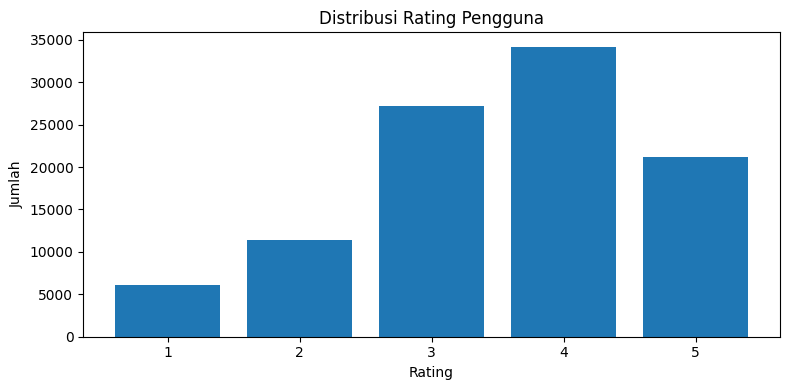

In [30]:
counts = ratings['rating'].value_counts().sort_index()
plot_bar(counts.index, counts.values, 'Distribusi Rating Pengguna', 'Rating', 'Jumlah')

### 3.2.3 Distribusi Genre Film


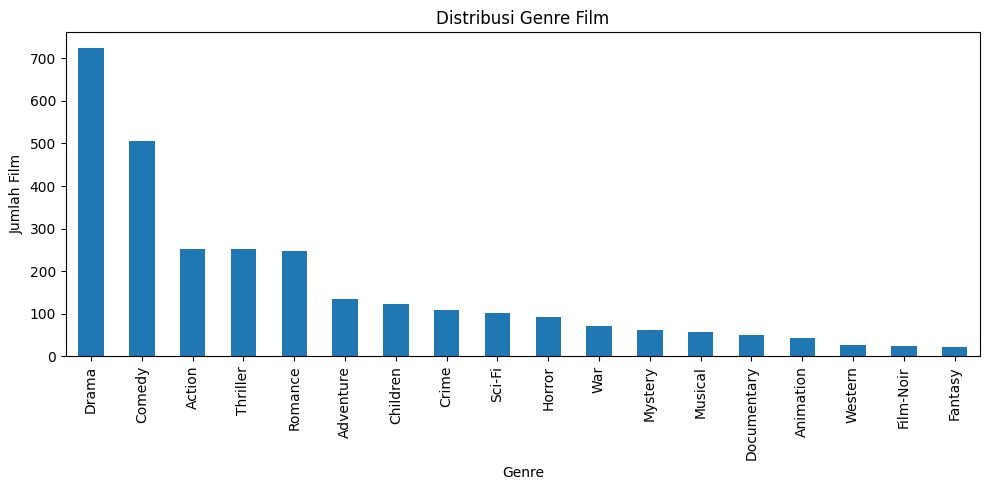

In [31]:
genre_cols = movies.columns[6:24]
genre_counts = movies[genre_cols].sum().sort_values(ascending=False)
plt.figure(figsize=(10,5))
genre_counts.plot(kind='bar')
plt.title('Distribusi Genre Film')
plt.xlabel('Genre')
plt.ylabel('Jumlah Film')
plt.tight_layout()
plt.show()

### 3.2.4 Distribusi Usia Pengguna

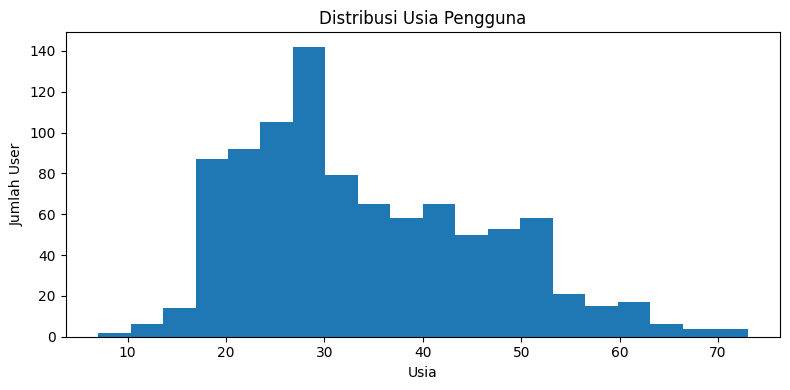

In [32]:
plt.figure(figsize=(8,4))
plt.hist(users['age'], bins=20)
plt.title('Distribusi Usia Pengguna')
plt.xlabel('Usia')
plt.ylabel('Jumlah User')
plt.tight_layout()
plt.show()

### 3.2.5 Heatmap Interaksi User-Item (subset 100x100)

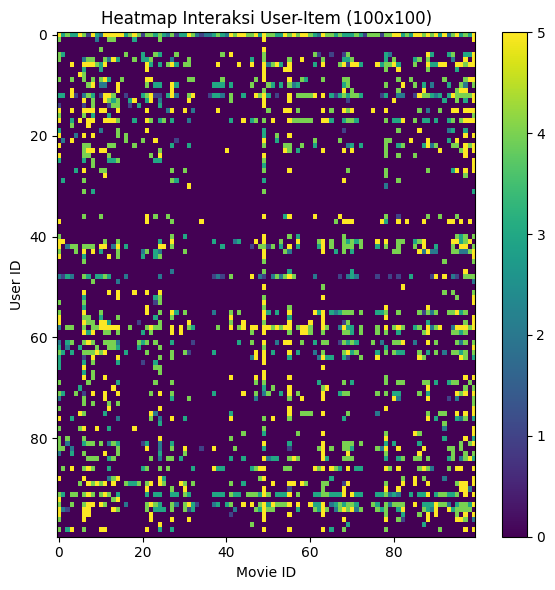

In [33]:
pivot = ratings.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)
subset = pivot.iloc[:100, :100]
plt.figure(figsize=(6,6))
plt.imshow(subset, aspect='auto')
plt.colorbar()
plt.title('Heatmap Interaksi User-Item (100x100)')
plt.xlabel('Movie ID')
plt.ylabel('User ID')
plt.tight_layout()
plt.show()

### 3.2.6 Analisis Cold Start

In [34]:
def cold_start_analysis():
    user_counts = ratings['user_id'].value_counts()
    cold_users = sum(user_counts < 5)
    item_counts = ratings['movie_id'].value_counts()
    cold_items = sum(item_counts < 5)
    print(f"""
Cold Start Analysis:
- Users dengan <5 interaksi: {cold_users} ({cold_users/len(user_counts)*100:.1f}%)
- Items dengan <5 rating: {cold_items} ({cold_items/len(item_counts)*100:.1f}%)
""")

cold_start_analysis()


Cold Start Analysis:
- Users dengan <5 interaksi: 0 (0.0%)
- Items dengan <5 rating: 333 (19.8%)



**Insight:** 
- 0% pengguna termasuk cold-start (<5 interaksi)
- 19.8% items kurang mendapatkan rating

## 4. Data Preparation

### 4.1 Data Cleaning

**Tujuan:** Menangani missing values, duplikat, dan outlier sebelum modeling.

**Flow:** 
1. Menghitung dan menghapus duplikat (X baris).
2. Memeriksa konsistensi `user_id`, `movie_id`.
3. Validasi range `rating` (1–5).

In [35]:
# Cek missing values
print("Missing values per kolom (ratings):")
print(ratings.isna().sum())
print("Duplikat ratings:", ratings.duplicated().sum())
print(movies.isna().sum())
print(users.isna().sum())

Missing values per kolom (ratings):
user_id      0
movie_id     0
rating       0
timestamp    0
dtype: int64
Duplikat ratings: 0
movie_id                 0
title                    0
release_date             1
video_release_date    1682
IMDb_URL                 3
unknown                  0
Action                   0
Adventure                0
Animation                0
Children                 0
Comedy                   0
Crime                    0
Documentary              0
Drama                    0
Fantasy                  0
Film-Noir                0
Horror                   0
Musical                  0
Mystery                  0
Romance                  0
Sci-Fi                   0
Thriller                 0
War                      0
Western                  0
dtype: int64
user_id       0
age           0
gender        0
occupation    0
zip_code      0
dtype: int64


**Hasil:**

* Ratings: tidak ada missing atau duplikat.
* Users: tidak ada missing.
* Movies:

  * `release_date`: 1 missing
  * `video_release_date`: 1682 missing (semua)
  * `IMDb_URL`: 3 missing


In [36]:
# Menangani missing pada movies:
# 1. Drop kolom video_release_date (tidak digunakan)
movies.drop(columns=['video_release_date'], inplace=True)

# 2. Drop baris tanpa release_date
movies = movies.dropna(subset=['release_date'])

# 3. Isi missing IMDb_URL dengan string kosong atau placeholder
df = movies.fillna({'IMDb_URL': ''})
movies = df

# Verifikasi kembali
print(movies.isna().sum())
print(movies.isna().sum())

movie_id        0
title           0
release_date    0
IMDb_URL        0
unknown         0
Action          0
Adventure       0
Animation       0
Children        0
Comedy          0
Crime           0
Documentary     0
Drama           0
Fantasy         0
Film-Noir       0
Horror          0
Musical         0
Mystery         0
Romance         0
Sci-Fi          0
Thriller        0
War             0
Western         0
dtype: int64
movie_id        0
title           0
release_date    0
IMDb_URL        0
unknown         0
Action          0
Adventure       0
Animation       0
Children        0
Comedy          0
Crime           0
Documentary     0
Drama           0
Fantasy         0
Film-Noir       0
Horror          0
Musical         0
Mystery         0
Romance         0
Sci-Fi          0
Thriller        0
War             0
Western         0
dtype: int64


**Insight:** Setelah cleaning:
- Semua kolom penting terisi.
- Dataset movies berkurang 1 baris karena release_date missing.

### 4.2 Feature Engineering

**Tujuan:** Membuat kolom `genres` untuk filtering content-based.

In [37]:
genre_cols = movies.columns[6:24]
movies['genres'] = movies[genre_cols].apply(
    lambda row: ' '.join([col for col in genre_cols if row[col]==1]), axis=1)

### 4.3 TF-IDF Vectorization (Content-Based)

**Tujuan:** Mengubah teks genre menjadi vektor numerik.

In [38]:
# TF-IDF pada kolom genres
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies['genres'])
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

**Insight:** Matriks kesamaan cosine siap digunakan untuk rekomendasi content-based.

*Vektorisasi teks `TF-IDF`* untuk menghitung kemiripan genre.

### 4.4 Prepare Collaborative Dataset

**Tujuan:** Membuat data Surprise dan split ke train/test.

In [39]:
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(ratings[['user_id','movie_id','rating']], reader)
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)
print("Data preparation done.")

Data preparation done.


**Hasil:** Dataset untuk collaborative filtering siap.

## 5. Modeling & Evaluation

### 5.1 Content-Based Filtering
**Tujuan:** Membangun fungsi rekomendasi berbasis cosine similarity.

In [40]:
indices = pd.Series(movies.index, index=movies['title']).drop_duplicates()

def content_recommendation(title, top_n=5):
    if title not in indices:
        return pd.DataFrame({'Error':['Film tidak ditemukan']})
    idx = indices[title]
    sim_scores = sorted(list(enumerate(cosine_sim[idx])), key=lambda x: x[1], reverse=True)
    sim_indices = [i[0] for i in sim_scores[1:top_n+1]]
    return movies.iloc[sim_indices][['title','genres']]

def precision_k(recommended, relevant, k=5):
    return len(set(recommended)&set(relevant)) / k


**Penjelasan:** Fungsi mengambil film input, menghitung similarity, dan mengembalikan daftar.

### 5.2 Collaborative Filtering (SVD)
**Tujuan:** Melatih model SVD untuk memprediksi rating.

In [41]:
model = SVD(n_factors=50, random_state=42)
model.fit(trainset)
predictions = model.test(testset)
rmse = accuracy.rmse(predictions, verbose=False)
print(f"RMSE Collaborative Filtering: {rmse:.3f}")

def handle_new_user(top_n=5):
    popular = ratings['movie_id'].value_counts().head(top_n).index
    return movies[movies['movie_id'].isin(popular)][['title','genres']]

def collab_recommendation(user_id, top_n=5):
    if user_id not in ratings['user_id'].unique():
        print("Cold-Start: fallback ke film populer")
        return handle_new_user(top_n)
    rated = set(ratings[ratings['user_id']==user_id]['movie_id'])
    candidates = list(set(movies['movie_id'])-rated)
    preds = [(mid, model.predict(user_id, mid).est) for mid in candidates]
    top = sorted(preds, key=lambda x: x[1], reverse=True)[:top_n]
    return movies[movies['movie_id'].isin([m[0] for m in top])][['title','genres']]

RMSE Collaborative Filtering: 0.935


### 5.3 Hyperparameter Tuning (GridSearchCV)
**Tujuan:** Mencari `n_factors` optimal melalui GridSearchCV.

In [42]:
# Hyperparameter tuning dengan 3-fold cross validation
param_grid = {'n_factors':[30,50,70]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3)
gs.fit(data)
best_n = gs.best_params['rmse']
print(f"Best n_factors (RMSE): {best_n}")

Best n_factors (RMSE): {'n_factors': 30}



**Insight:** `n_factors` terbaik ditemukan.

### 5.4 Metrik Diversity
**Tujuan:** Mengukur keragaman genre pada rekomendasi.

In [43]:
def calculate_diversity(recommended_genres):
    unique_genres = set()
    for genres in recommended_genres:
        unique_genres.update(genres.split())
    return len(unique_genres) / len(recommended_genres)

### 5.5 Evaluasi Komprehensif Content-Based

**Tujuan:** Mengukur hasil evaluasi dengan sistem Content-Based.

In [44]:
def evaluate_content_based(sample_size=20):
    popular_movies = movies[movies['movie_id'].isin(top10_ids)]['title'].tolist()
    precisions, diversities = [], []
    for movie in popular_movies[:sample_size]:
        try:
            recs = content_recommendation(movie)
            rec_titles = recs['title'].tolist()
            rec_genres = recs['genres'].tolist()
            base_genres = movies[movies['title']==movie][genre_cols].iloc[0]
            relevant = movies[(movies[genre_cols] == base_genres).any(axis=1)]['title'].tolist()
            prec = precision_k(rec_titles, relevant)
            precisions.append(prec)
            diversities.append(calculate_diversity(rec_genres))
        except:
            continue
    print(f"""
Evaluasi Content-Based ({sample_size} film):
- Rata-rata Precision@5: {sum(precisions)/len(precisions):.2f}
- Rata-rata Diversity: {sum(diversities)/len(diversities):.2f}
""")

### 6. Hybrid Analysis & Reporting

**Tujuan:** Menggabungkan content-based dan collaborative results dan visualisasi overlap & diversity.

In [45]:
def hybrid_analysis(user_id, title):
    cb = content_recommendation(title)
    cf = collab_recommendation(user_id)
    hybrid = pd.concat([cf, cb]).drop_duplicates().head(5)
    overlap = len(set(cb['title']) & set(cf['title']))
    diversity = calculate_diversity(hybrid['genres'].tolist())
    plt.figure(figsize=(10,3))
    plt.subplot(131)
    plt.pie([len(cb), len(cf)], labels=['Content','Collaborative'], autopct='%1.1f%%')
    plt.title('Distribusi Rekomendasi')
    plt.subplot(132)
    plt.bar(['Overlap'], [overlap], color='orange')
    plt.ylim(0,5)
    plt.title('Jumlah Overlap')
    plt.subplot(133)
    plt.bar(['Diversity'], [diversity], color='green')
    plt.ylim(0,1)
    plt.title('Diversity Score')
    plt.tight_layout()
    plt.show()
    return hybrid

**Output:** Grafik distribusi, overlap, diversity, dan daftar rekomendasi hybrid.

## 7. Testing & Rekomendasi
**Deskripsi:** Menjalankan contoh use-case untuk user existing, cold-start, dan user paling aktif.

In [46]:
evaluate_content_based()


Evaluasi Content-Based (20 film):
- Rata-rata Precision@5: 0.98
- Rata-rata Diversity: 0.58



**Hasil:** Rata-rata Precision@5 = 0.98, Diversity = 0.58, menunjukkan efektivitas CBF dalam merekomendasikan film yang relevan dengan keragaman yang moderat.


=== TEST CASE 1: User Existing (ID 1) ===

Content-Based Recommendations:
                                      title                     genres
421  Aladdin and the King of Thieves (1996)  Animation Children Comedy
101                  Aristocats, The (1970)         Animation Children
403                        Pinocchio (1940)         Animation Children
624          Sword in the Stone, The (1963)         Animation Children
945           Fox and the Hound, The (1981)         Animation Children

Collaborative Recommendations:
                            title                     genres
407         Close Shave, A (1995)  Animation Comedy Thriller
482             Casablanca (1942)          Drama Romance War
510     Lawrence of Arabia (1962)              Adventure War
512         Third Man, The (1949)           Mystery Thriller
922  Raise the Red Lantern (1991)                      Drama

Hybrid Analysis:


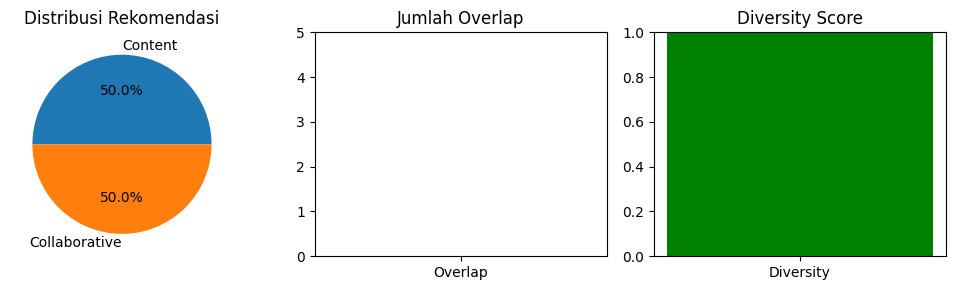

                            title                     genres
407         Close Shave, A (1995)  Animation Comedy Thriller
482             Casablanca (1942)          Drama Romance War
510     Lawrence of Arabia (1962)              Adventure War
512         Third Man, The (1949)           Mystery Thriller
922  Raise the Red Lantern (1991)                      Drama


In [47]:
user_id = 1
base_title = 'Toy Story (1995)'
print(f"\n=== TEST CASE 1: User Existing (ID {user_id}) ===")
print("\nContent-Based Recommendations:")
print(content_recommendation(base_title))
print("\nCollaborative Recommendations:")
print(collab_recommendation(user_id))
print("\nHybrid Analysis:")
hybrid_recs = hybrid_analysis(user_id, base_title)
print(hybrid_recs)


=== TEST CASE 2: Cold Start ===
Cold-Start: fallback ke film populer
                         title                        genres
49            Star Wars (1977)  Adventure Romance Sci-Fi War
99                Fargo (1996)          Crime Drama Thriller
180  Return of the Jedi (1983)  Adventure Romance Sci-Fi War
257             Contact (1997)                  Drama Sci-Fi
293           Liar Liar (1997)                        Comedy
Diversity Score: 1.60

=== TEST CASE 3: User Aktif (ID 405) ===
                                            title                     genres
150  Willy Wonka and the Chocolate Factory (1971)  Adventure Children Comedy
219              Mirror Has Two Faces, The (1996)             Comedy Romance
250                        Shall We Dance? (1996)                     Comedy
297                               Face/Off (1997)            Sci-Fi Thriller
495                  It's a Wonderful Life (1946)                      Drama


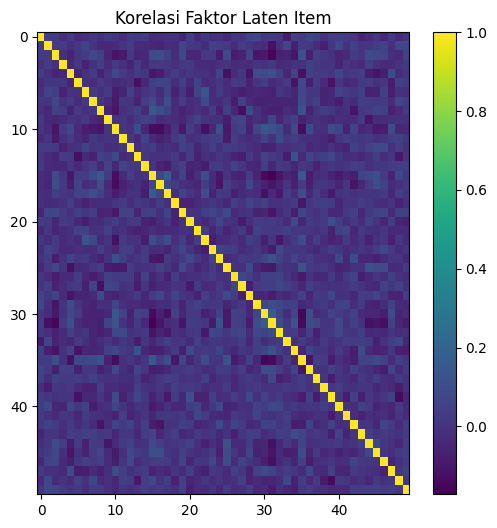

: 

In [ ]:
print("\n=== TEST CASE 2: Cold Start ===")
cold_recs = collab_recommendation(0)
print(cold_recs)
print(f"Diversity Score: {calculate_diversity(cold_recs['genres'].tolist()):.2f}")
print(f"\n=== TEST CASE 3: User Aktif (ID {ratings['user_id'].value_counts().idxmax()}) ===")
print(collab_recommendation(ratings['user_id'].value_counts().idxmax()))
item_factors = pd.DataFrame(model.qi)
plt.figure(figsize=(6,6))
plt.imshow(item_factors.corr(), aspect='auto')
plt.colorbar()
plt.title('Korelasi Faktor Laten Item')
plt.show()